# Track bet slips


Current running profit/loss: $ 2.09 for 1 in each bet

Current running actual profit/loss: $ 1881.0 since starting stack
       event_id  bet_amount hilow  line  result_corner  is_win   pnl  \
0  20200305THU4       900.0   Low   6.5            7.0       0 -1.00   
1  20200305THU9       900.0  High  10.5           11.0       1  1.95   
2  20200306FRI1       900.0   Low   7.5            6.0       1  0.40   
3  20200306FRI4       900.0   Low  15.5           14.0       1  0.29   
4  20200308SUN1       900.0   Low   8.5            7.0       1  0.45   

   pnl_actual  
0      -900.0  
1      1755.0  
2       360.0  
3       261.0  
4       405.0  


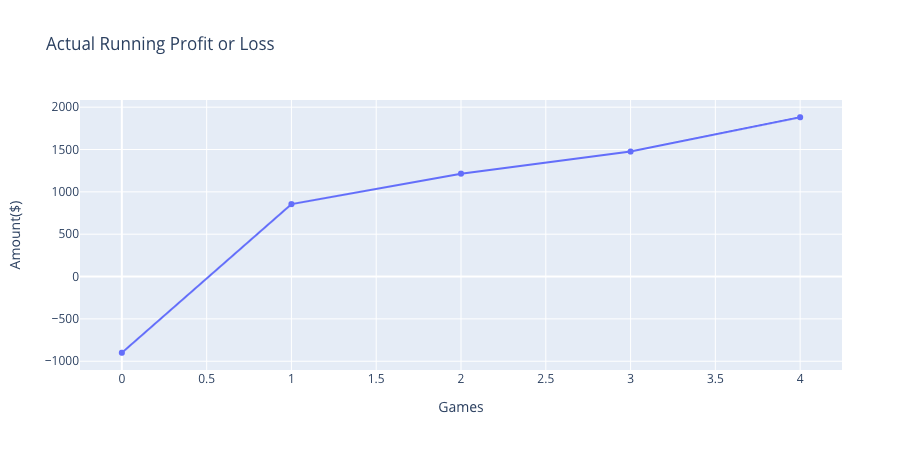

In [13]:
import pandas as pd
import numpy as np
import re
import utils as u
from tqdm import tqdm

result = pd.read_csv('/Users/TysonWu/dev/odds-crawl-app/odds-crawl-app/development/result_collection/match_corner_result.csv')
data = pd.read_csv('bet_slips/receipt.txt', sep=";", header=None)
data = data[[0,8,14,15,16]]
data = data.rename(columns={0:'event_id', 
                            8: 'send_bet_status', 
                            14: 'hilow_content', 
                            15: 'odds', 
                            16: 'bet_amount'})
data['hilow'] = data['hilow_content'].apply(lambda x: x.split("[")[0])
data['line'] = data['hilow_content'].apply(lambda x: re.sub('@|]','',x.split("[")[-1]))
data['bet_amount'] = data['bet_amount'].apply(lambda x: re.sub('\$','',x).strip())
data['bet_amount'] = data['bet_amount'].apply(pd.to_numeric)
data['odds'] = data['odds'].apply(pd.to_numeric)
data['line'] = data['line'].apply(pd.to_numeric)
data = data[data.send_bet_status.str.contains('Accepted')]
del data['hilow_content']

# merge with results
data = data.merge(result[['event_id','result_corner']], how='inner', on='event_id')
data['result_corner'] = data['result_corner'].apply(pd.to_numeric)
data['is_win'] = np.where(data.hilow == 'Low', 
                          np.where(data.line>data.result_corner,1,0), 
                          np.where(data.line<data.result_corner,1,0))
data['pnl'] = np.where(data.is_win == 1, data.odds - 1, -1)
data['pnl_actual'] = data.bet_amount * data.pnl
print('\nCurrent running profit/loss: $ {} for 1 in each bet'.format(round(data['pnl'].sum(),2)))
print('\nCurrent running actual profit/loss: $ {} since starting stack'.format(round(data['pnl_actual'].sum(),2)))
print(data[['event_id','bet_amount','hilow','line','result_corner','is_win','pnl','pnl_actual']])
# u.graph(data.index, data.pnl.cumsum(), 'Running returns')

import plotly.graph_objects as go
fig = go.Figure(data=go.Scatter(x=data.index, y=data.pnl_actual.cumsum()))
fig.update_layout(title='Actual Running Profit or Loss',
                   xaxis_title='Games',
                   yaxis_title='Amount($)')
fig.show()

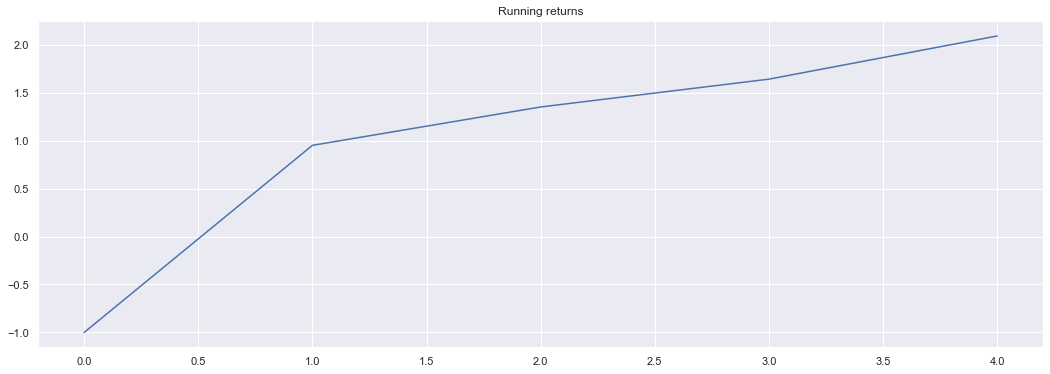